# AnoGAN
<hr/>

#### Parameter 조정
- epochs: 높을 때 보다 낮을 때가 좋았으며, 100 과 64 비교 시 structure 모양에 따라 각각 anomaly score의 차이가 다름
- learning_rate: 1e-5 => 2e-1 (큰 차이는 없지만 2e-1)이 조금 더 나음
- learning_G_per_D: 1 일 때가 가장 좋은 결과 값이 나옴
- 마지막 test 사진은, 정확도가 떨어짐
- 구조가 복잡한 건 잘 잡히지 않음

#### parameter
- 2020.08.16
> latent_size = 100  
> workers = 4 
> img_size = 64  
> channel = 1  
> epochs = 100  
> batch_size = 64  
> **learning_rate = 3e-2  
> learning_G_per_D = 10**


# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 3e-2

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
# data_root = "../../dataset/train"
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# Model

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 10)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3831 / G_loss : 0.0145
- D(x) : 0.5026 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.9856
[1/100][1/14]
- D_loss : 4.2819 / G_loss : 2.9008
- D(x) : 0.9732 / D(G(z1)) : 0.9858 / D(G(z2)) : 0.0550
[1/100][2/14]
- D_loss : 3.3390 / G_loss : 0.5521
- D(x) : 0.0379 / D(G(z1)) : 0.0538 / D(G(z2)) : 0.5757
[1/100][3/14]
- D_loss : 1.5433 / G_loss : 0.4760
- D(x) : 0.5001 / D(G(z1)) : 0.5675 / D(G(z2)) : 0.6214
[1/100][4/14]
- D_loss : 1.6688 / G_loss : 0.7590
- D(x) : 0.5343 / D(G(z1)) : 0.6449 / D(G(z2)) : 0.4684
[1/100][5/14]
- D_loss : 1.5137 / G_loss : 0.5944
- D(x) : 0.4139 / D(G(z1)) : 0.4659 / D(G(z2)) : 0.5519
[1/100][6/14]
- D_loss : 1.5165 / G_loss : 0.6239
- D(x) : 0.4626 / D(G(z1)) : 0.5228 / D(G(z2)) : 0.5361
[1/100][7/14]
- D_loss : 1.3622 / G_loss : 0.5156
- D(x) : 0.5140 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5973
[1/100][8/14]
- D_loss : 1.4540 / G_loss : 0.7383
- D(x) : 0.5350 / D(G(z1)) : 0.5592 / D(G(z2)) : 0.4781
[1/100][9/14]
- D_loss : 1.4165 / G_loss : 0.6

[6/100][8/14]
- D_loss : 1.4047 / G_loss : 0.5339
- D(x) : 0.4337 / D(G(z1)) : 0.4340 / D(G(z2)) : 0.5863
[6/100][9/14]
- D_loss : 1.4167 / G_loss : 0.8743
- D(x) : 0.5859 / D(G(z1)) : 0.5861 / D(G(z2)) : 0.4172
[6/100][10/14]
- D_loss : 1.4148 / G_loss : 0.5863
- D(x) : 0.4168 / D(G(z1)) : 0.4170 / D(G(z2)) : 0.5564
[6/100][11/14]
- D_loss : 1.3997 / G_loss : 0.7047
- D(x) : 0.5559 / D(G(z1)) : 0.5562 / D(G(z2)) : 0.4943
[6/100][12/14]
- D_loss : 1.3867 / G_loss : 0.7378
- D(x) : 0.4939 / D(G(z1)) : 0.4941 / D(G(z2)) : 0.4782
[6/100][13/14]
- D_loss : 1.3890 / G_loss : 0.6602
- D(x) : 0.4772 / D(G(z1)) : 0.4776 / D(G(z2)) : 0.5168
[7/100][0/14]
- D_loss : 1.3880 / G_loss : 0.6830
- D(x) : 0.5160 / D(G(z1)) : 0.5163 / D(G(z2)) : 0.5051
[7/100][1/14]
- D_loss : 1.3870 / G_loss : 0.7129
- D(x) : 0.5040 / D(G(z1)) : 0.5043 / D(G(z2)) : 0.4902
[7/100][2/14]
- D_loss : 1.3875 / G_loss : 0.6801
- D(x) : 0.4890 / D(G(z1)) : 0.4894 / D(G(z2)) : 0.5066
[7/100][3/14]
- D_loss : 1.3869 / G_loss :

[12/100][1/14]
- D_loss : 1.3864 / G_loss : 0.6917
- D(x) : 0.4996 / D(G(z1)) : 0.4997 / D(G(z2)) : 0.5007
[12/100][2/14]
- D_loss : 1.3865 / G_loss : 0.6940
- D(x) : 0.5005 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.4995
[12/100][3/14]
- D_loss : 1.3865 / G_loss : 0.6926
- D(x) : 0.4993 / D(G(z1)) : 0.4994 / D(G(z2)) : 0.5003
[12/100][4/14]
- D_loss : 1.3864 / G_loss : 0.6927
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5002
[12/100][5/14]
- D_loss : 1.3864 / G_loss : 0.6923
- D(x) : 0.4999 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5004
[12/100][6/14]
- D_loss : 1.3865 / G_loss : 0.6922
- D(x) : 0.5001 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5005
[12/100][7/14]
- D_loss : 1.3865 / G_loss : 0.6935
- D(x) : 0.5002 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.4998
[12/100][8/14]
- D_loss : 1.3864 / G_loss : 0.6920
- D(x) : 0.4996 / D(G(z1)) : 0.4997 / D(G(z2)) : 0.5006
[12/100][9/14]
- D_loss : 1.3864 / G_loss : 0.6933
- D(x) : 0.5003 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.4999
[12/100][10/14]
- D_loss : 1.3864 / G

[17/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6941
- D(x) : 0.5005 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.4995
[17/100][9/14]
- D_loss : 1.3864 / G_loss : 0.6914
- D(x) : 0.4994 / D(G(z1)) : 0.4995 / D(G(z2)) : 0.5009
[17/100][10/14]
- D_loss : 1.3864 / G_loss : 0.6945
- D(x) : 0.5008 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.4993
[17/100][11/14]
- D_loss : 1.3864 / G_loss : 0.6916
- D(x) : 0.4992 / D(G(z1)) : 0.4993 / D(G(z2)) : 0.5008
[17/100][12/14]
- D_loss : 1.3864 / G_loss : 0.6947
- D(x) : 0.5007 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.4992
[17/100][13/14]
- D_loss : 1.3864 / G_loss : 0.6913
- D(x) : 0.4992 / D(G(z1)) : 0.4992 / D(G(z2)) : 0.5009
[18/100][0/14]
- D_loss : 1.3864 / G_loss : 0.6945
- D(x) : 0.5009 / D(G(z1)) : 0.5009 / D(G(z2)) : 0.4993
[18/100][1/14]
- D_loss : 1.3864 / G_loss : 0.6916
- D(x) : 0.4992 / D(G(z1)) : 0.4993 / D(G(z2)) : 0.5008
[18/100][2/14]
- D_loss : 1.3864 / G_loss : 0.6952
- D(x) : 0.5007 / D(G(z1)) : 0.5007 / D(G(z2)) : 0.4990
[18/100][3/14]
- D_loss : 1.3863 

[23/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6935
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4998
[23/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6927
- D(x) : 0.4998 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5002
[23/100][3/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5002 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.4999
[23/100][4/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.4999
[23/100][5/14]
- D_loss : 1.3863 / G_loss : 0.6927
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5002
[23/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6936
- D(x) : 0.5002 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.4998
[23/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6927
- D(x) : 0.4997 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5002
[23/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6936
- D(x) : 0.5002 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.4998
[23/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6925
- D(x) : 0.4997 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5003
[23/100][10/14]
- D_loss : 1.3863 / G

[28/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5000
[28/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[28/100][10/14]
- D_loss : 1.3863 / G_loss : 0.6929
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[28/100][11/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[28/100][12/14]
- D_loss : 1.3863 / G_loss : 0.6928
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5002
[28/100][13/14]
- D_loss : 1.3863 / G_loss : 0.6935
- D(x) : 0.5002 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.4998
[29/100][0/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4998 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5001
[29/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5000
[29/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.4999 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[29/100][3/14]
- D_loss : 1.3863 

[34/100][1/14]
- D_loss : 1.3876 / G_loss : 0.7267
- D(x) : 0.5180 / D(G(z1)) : 0.5180 / D(G(z2)) : 0.4835
[34/100][2/14]
- D_loss : 1.3874 / G_loss : 0.6661
- D(x) : 0.4835 / D(G(z1)) : 0.4835 / D(G(z2)) : 0.5137
[34/100][3/14]
- D_loss : 1.3871 / G_loss : 0.7109
- D(x) : 0.5137 / D(G(z1)) : 0.5137 / D(G(z2)) : 0.4912
[34/100][4/14]
- D_loss : 1.3866 / G_loss : 0.6853
- D(x) : 0.4912 / D(G(z1)) : 0.4912 / D(G(z2)) : 0.5040
[34/100][5/14]
- D_loss : 1.3864 / G_loss : 0.6936
- D(x) : 0.5040 / D(G(z1)) : 0.5040 / D(G(z2)) : 0.4998
[34/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6965
- D(x) : 0.4998 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.4983
[34/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6891
- D(x) : 0.4983 / D(G(z1)) : 0.4983 / D(G(z2)) : 0.5021
[34/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6960
- D(x) : 0.5020 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.4986
[34/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6920
- D(x) : 0.4986 / D(G(z1)) : 0.4986 / D(G(z2)) : 0.5006
[34/100][10/14]
- D_loss : 1.3863 / G

[39/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6939
- D(x) : 0.5004 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.4996
[39/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6925
- D(x) : 0.4996 / D(G(z1)) : 0.4996 / D(G(z2)) : 0.5003
[39/100][10/14]
- D_loss : 1.3863 / G_loss : 0.6935
- D(x) : 0.5003 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.4998
[39/100][11/14]
- D_loss : 1.3863 / G_loss : 0.6926
- D(x) : 0.4998 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5003
[39/100][12/14]
- D_loss : 1.3863 / G_loss : 0.6934
- D(x) : 0.5002 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.4999
[39/100][13/14]
- D_loss : 1.3863 / G_loss : 0.6928
- D(x) : 0.4998 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5002
[40/100][0/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5002 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.4999
[40/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5000
[40/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[40/100][3/14]
- D_loss : 1.3863 

[45/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6923
- D(x) : 0.4993 / D(G(z1)) : 0.4994 / D(G(z2)) : 0.5004
[45/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6935
- D(x) : 0.5004 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.4998
[45/100][3/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.4998 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5000
[45/100][4/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[45/100][5/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[45/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5001
[45/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5000
[45/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[45/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[45/100][10/14]
- D_loss : 1.3863 / G

[50/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6902
- D(x) : 0.4989 / D(G(z1)) : 0.4989 / D(G(z2)) : 0.5015
[50/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6974
- D(x) : 0.5014 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.4979
[50/100][10/14]
- D_loss : 1.3863 / G_loss : 0.6873
- D(x) : 0.4979 / D(G(z1)) : 0.4979 / D(G(z2)) : 0.5029
[50/100][11/14]
- D_loss : 1.3863 / G_loss : 0.7009
- D(x) : 0.5029 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.4961
[50/100][12/14]
- D_loss : 1.3864 / G_loss : 0.6831
- D(x) : 0.4961 / D(G(z1)) : 0.4961 / D(G(z2)) : 0.5050
[50/100][13/14]
- D_loss : 1.3864 / G_loss : 0.7053
- D(x) : 0.5050 / D(G(z1)) : 0.5050 / D(G(z2)) : 0.4940
[51/100][0/14]
- D_loss : 1.3865 / G_loss : 0.6794
- D(x) : 0.4939 / D(G(z1)) : 0.4939 / D(G(z2)) : 0.5069
[51/100][1/14]
- D_loss : 1.3865 / G_loss : 0.7079
- D(x) : 0.5069 / D(G(z1)) : 0.5069 / D(G(z2)) : 0.4927
[51/100][2/14]
- D_loss : 1.3865 / G_loss : 0.6778
- D(x) : 0.4927 / D(G(z1)) : 0.4927 / D(G(z2)) : 0.5077
[51/100][3/14]
- D_loss : 1.3865 

[56/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[56/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[56/100][3/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5000
[56/100][4/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[56/100][5/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.4999
[56/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[56/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[56/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[56/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[56/100][10/14]
- D_loss : 1.3863 / G

[61/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[61/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[61/100][10/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[61/100][11/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[61/100][12/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[61/100][13/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[62/100][0/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[62/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[62/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[62/100][3/14]
- D_loss : 1.3863 

[67/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5000
[67/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][3/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][4/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][5/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[67/100][10/14]
- D_loss : 1.3863 / G

[72/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[72/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[72/100][10/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5000
[72/100][11/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[72/100][12/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[72/100][13/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[73/100][0/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[73/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[73/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6931
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5000
[73/100][3/14]
- D_loss : 1.3863 

[78/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6941
- D(x) : 0.5004 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.4995
[78/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6921
- D(x) : 0.4995 / D(G(z1)) : 0.4995 / D(G(z2)) : 0.5005
[78/100][3/14]
- D_loss : 1.3863 / G_loss : 0.6942
- D(x) : 0.5005 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.4995
[78/100][4/14]
- D_loss : 1.3863 / G_loss : 0.6919
- D(x) : 0.4995 / D(G(z1)) : 0.4995 / D(G(z2)) : 0.5006
[78/100][5/14]
- D_loss : 1.3863 / G_loss : 0.6945
- D(x) : 0.5006 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.4993
[78/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6915
- D(x) : 0.4993 / D(G(z1)) : 0.4993 / D(G(z2)) : 0.5008
[78/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6949
- D(x) : 0.5008 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.4991
[78/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6911
- D(x) : 0.4991 / D(G(z1)) : 0.4991 / D(G(z2)) : 0.5010
[78/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6955
- D(x) : 0.5010 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.4988
[78/100][10/14]
- D_loss : 1.3863 / G

[83/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[83/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[83/100][10/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[83/100][11/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[83/100][12/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[83/100][13/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.5000 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5000
[84/100][0/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5001
[84/100][1/14]
- D_loss : 1.3863 / G_loss : 0.6933
- D(x) : 0.5001 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4999
[84/100][2/14]
- D_loss : 1.3863 / G_loss : 0.6930
- D(x) : 0.4999 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[84/100][3/14]
- D_loss : 1.3863 

[89/100][1/14]
- D_loss : 1.3865 / G_loss : 0.6831
- D(x) : 0.4937 / D(G(z1)) : 0.4937 / D(G(z2)) : 0.5051
[89/100][2/14]
- D_loss : 1.3864 / G_loss : 0.7002
- D(x) : 0.5051 / D(G(z1)) : 0.5051 / D(G(z2)) : 0.4965
[89/100][3/14]
- D_loss : 1.3863 / G_loss : 0.6891
- D(x) : 0.4965 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.5020
[89/100][4/14]
- D_loss : 1.3863 / G_loss : 0.6947
- D(x) : 0.5020 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.4992
[89/100][5/14]
- D_loss : 1.3863 / G_loss : 0.6932
- D(x) : 0.4992 / D(G(z1)) : 0.4992 / D(G(z2)) : 0.5000
[89/100][6/14]
- D_loss : 1.3863 / G_loss : 0.6923
- D(x) : 0.5000 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5004
[89/100][7/14]
- D_loss : 1.3863 / G_loss : 0.6943
- D(x) : 0.5004 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.4994
[89/100][8/14]
- D_loss : 1.3863 / G_loss : 0.6921
- D(x) : 0.4994 / D(G(z1)) : 0.4994 / D(G(z2)) : 0.5005
[89/100][9/14]
- D_loss : 1.3863 / G_loss : 0.6938
- D(x) : 0.5005 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.4997
[89/100][10/14]
- D_loss : 1.3863 / G

[94/100][6/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][7/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][8/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][9/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][10/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][11/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][12/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[94/100][13/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[95/100][0/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.00

[99/100][10/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[99/100][11/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[99/100][12/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[99/100][13/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[100/100][0/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[100/100][1/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[100/100][2/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[100/100][3/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) : 0.0000
[100/100][4/14]
- D_loss : 100.0000 / G_loss : 100.0000
- D(x) : 0.0000 / D(G(z1)) : 0.0000 / D(G(z2)) :

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

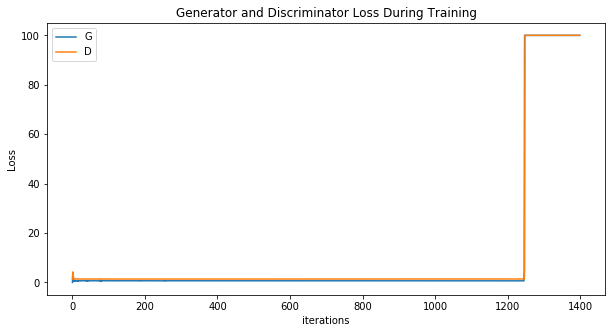

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

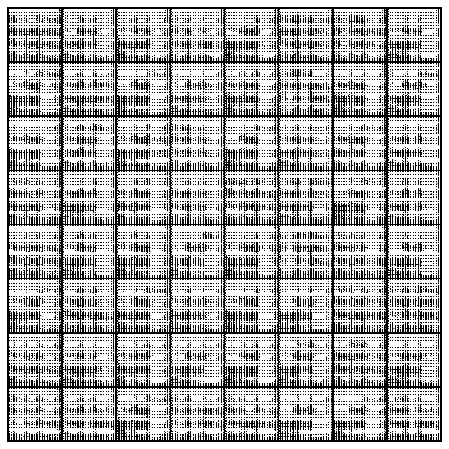

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature =  D(Test_Data)
    _, G_Data_feature    =  D(G_Data)
    residual_loss        =  torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss  =  torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss             =  (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_Ti64"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 3701.1836  Sum_of_z : 10.7584
[200]	 Ano_loss : 3650.9841  Sum_of_z : 10.1607
[400]	 Ano_loss : 3645.1243  Sum_of_z : 10.0556
picture  2
[0]	 Ano_loss : 4056.4617  Sum_of_z : 10.0728
[200]	 Ano_loss : 4016.8950  Sum_of_z : 8.3326
[400]	 Ano_loss : 4011.0464  Sum_of_z : 7.1134
picture  3
[0]	 Ano_loss : 3967.2637  Sum_of_z : 7.0511
[200]	 Ano_loss : 3874.4053  Sum_of_z : 5.9636
[400]	 Ano_loss : 3868.7361  Sum_of_z : 6.3871
picture  4
[0]	 Ano_loss : 4065.4060  Sum_of_z : 6.4073
[200]	 Ano_loss : 4044.9629  Sum_of_z : 4.8197
[400]	 Ano_loss : 4042.0349  Sum_of_z : 4.1431
picture  5
[0]	 Ano_loss : 4144.4570  Sum_of_z : 4.0219
[200]	 Ano_loss : 3931.9648  Sum_of_z : 1.6978
[400]	 Ano_loss : 3866.3311  Sum_of_z : 2.3732
picture  6
[0]	 Ano_loss : 4393.0586  Sum_of_z : 2.3525
[200]	 Ano_loss : 4322.8115  Sum_of_z : 3.6026
[400]	 Ano_loss : 4313.6138  Sum_of_z : 5.3673
picture  7
[0]	 Ano_loss : 3792.1191  Sum_of_z : 5.3658
[200]	 Ano_loss : 3743.6667  Sum_of_z : 

# Similar Z , Ano_Score and Segementation

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

In [16]:
diff_cnts = []

def compare_imgs(real_img, generated_img,i, reverse=False, threshold=50):
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

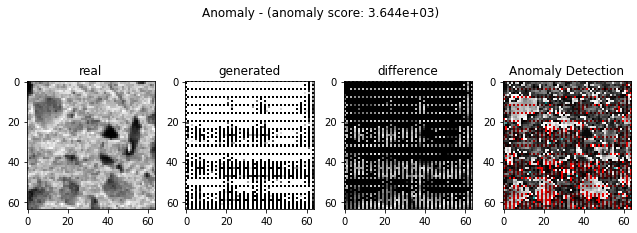

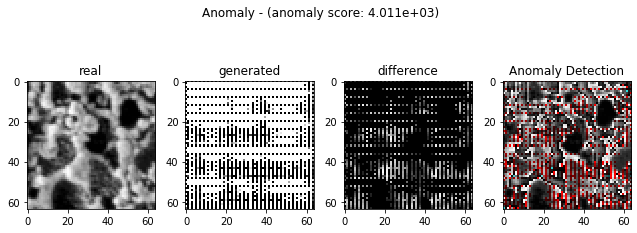

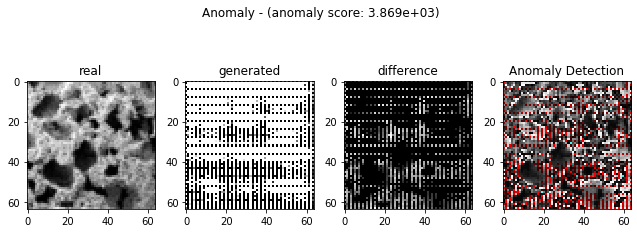

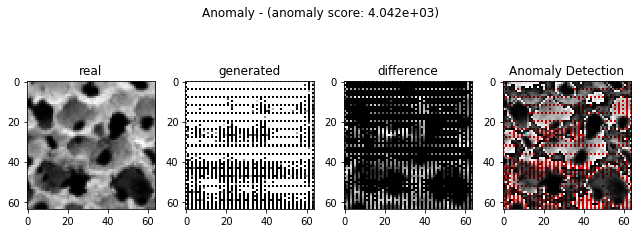

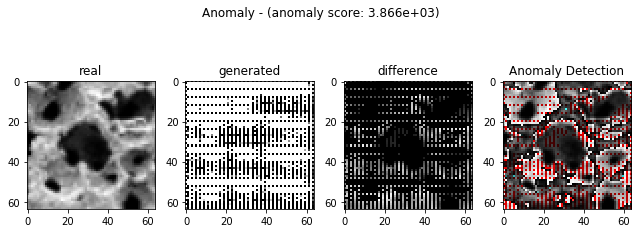

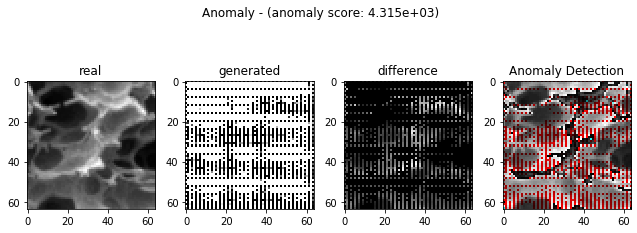

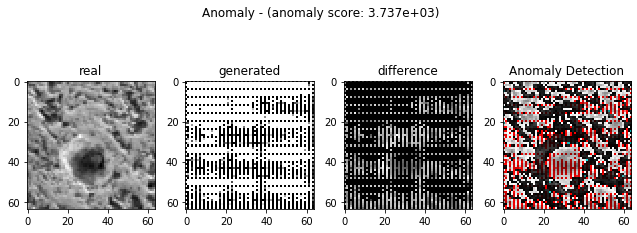

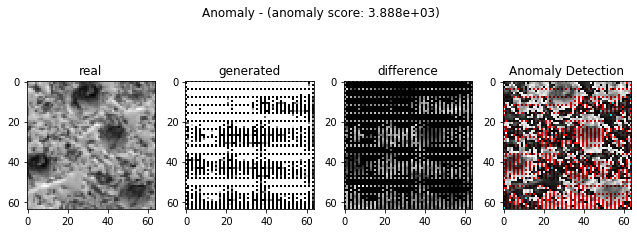

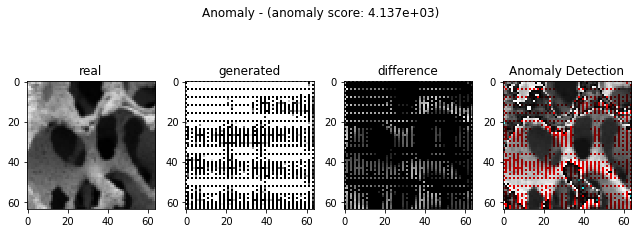

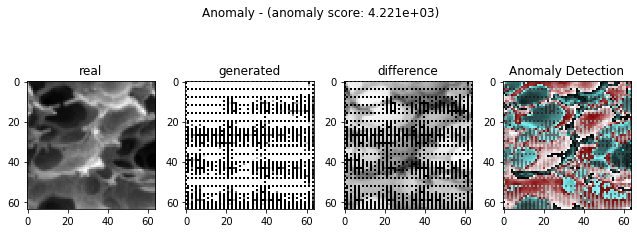

In [17]:
vali_label = [0,0,0,0,0,1,1,1,1,1,1]

for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

# AnoGAN 성능 확인: 상대밀도

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.27612305 0.23803711 0.25048828 0.24414062 0.23364258 0.2824707
 0.29614258 0.29663086 0.23583984 0.6862793 ]


In [19]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.2232251  1.05450439 1.10966309 1.08154297 1.03503662 1.25134521
 1.31191162 1.31407471 1.04477051 3.04021729]


### 분율 평균

In [20]:
# 분율 평균
print(sum(Ti64_rel_densitys)/len(Ti64_rel_densitys))

1.346629150390625
